import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm

# Example Data
data = np.array([[0.1, 0.2], [0.4, 0.5], [0.3, 0.7], [0.8, 0.9], [0.2, 0.3]])

# Silverman Bandwidth Calculation
def silverman_bw(data):
    d = data.shape[1]
    n = data.shape[0]
    std = np.std(data, axis=0)
    interquartile = (np.percentile(data, 75, axis=0) - np.percentile(data, 25, axis=0)) / 1.34
    k = (9 * 3 ** (1 / 5)) / (10 * 2 ** (2 / 5)) * (4 / (d + 2)) ** (1 / (d + 4))
    A = np.minimum(std, interquartile)
    return k * n ** (-1 / (d + 4)) * A

bandwidth = silverman_bw(data)

# KDE using Silverman Bandwidth
#kde = gaussian_kde(data.T, bw_method='silverman')
kde = gaussian_kde(data.T / bandwidth)
# Scaling bandwidth during initialization
#kde.set_bandwidth(bw_method=kde.factor * bandwidth)




# HDP Regions Calculation
def find_hdp_pdf_values(pdf_values, probability):
    pdf_sort_list = np.sort(pdf_values)[::-1]
    cdf_sort_list = np.cumsum(pdf_sort_list) / np.sum(pdf_sort_list)
    position_at_cdf = np.argmax(cdf_sort_list >= probability)
    return pdf_sort_list[position_at_cdf]

def n_sigma_probability(n):
    return norm.cdf(n) - norm.cdf(-n)

one_sigma_probability = n_sigma_probability(1)
two_sigma_probability = n_sigma_probability(2)

one_sigma_pdf_value = find_hdp_pdf_values(kde.pdf(data.T), one_sigma_probability)
two_sigma_pdf_value = find_hdp_pdf_values(kde.pdf(data.T), two_sigma_probability)

# Plotting Sigma Contours
def plot_sigma_contours(data_for_contours, limiting_pdf_values, xlim, ylim, **kwargs):
    x, y = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
    positions = np.vstack([x.ravel(), y.ravel()])
    z = np.reshape(kde(positions).T, x.shape)
    plt.contour(x, y, z, levels=limiting_pdf_values, **kwargs)

plot_sigma_contours(data, [one_sigma_pdf_value, two_sigma_pdf_value], [0, 1], [0, 1], colors=['k', 'k'])
plt.show()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats,optimize
rand_seed=100

In [26]:
def make_data_normal(data_count=100):
    np.random.seed(rand_seed)
    x=np.random.normal(0,1,data_count)
    dist=lambda z:stats.norm(0,1).pdf(z)
    return x,dist

def make_data_binormal(data_count=100):
    alpha = 0.3
    np.random.seed(rand_seed)
    x = np.concatenate([
        np.random.normal(-1, 2, int(data_count * alpha)),
        np.random.normal(5, 1, int(data_count * (1 - alpha)))
    ])
    dist = lambda z: alpha * stats.norm(-1, 2).pdf(z) + (1 - alpha) * stats.norm(5, 1).pdf(z)
    return x, dist

def make_data_exp(data_count=100):
    alpha = 0.3
    np.random.seed(rand_seed)
    x = np.concatenate([
        np.random.exponential(1, int(data_count * alpha)),
        np.random.exponential(1, int(data_count * (1 - alpha))) + 1
    ])
    dist = lambda z: alpha * stats.expon(0).pdf(z) + (1 - alpha) * stats.expon(1).pdf(z)
    return x, dist
    
def make_data_uniform(data_count=100):
    alpha = 0.3
    np.random.seed(rand_seed)
    x = np.concatenate([
        np.random.uniform(-1, 1, int(data_count * alpha)),
        np.random.uniform(0, 1, int(data_count * (1 - alpha)))
    ])
    dist = lambda z: alpha * stats.uniform(-1, 1).pdf(z) + (1 - alpha) * stats.uniform(0, 1).pdf(z)
    return x, dist

x_norm, dist_norm = make_data_normal()
x_binorm, dist_binorm = make_data_binormal()
x_exp, dist_exp = make_data_exp()
x_uni, dist_uni = make_data_uniform()

/tmp/ipykernel_203885/2629210754.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


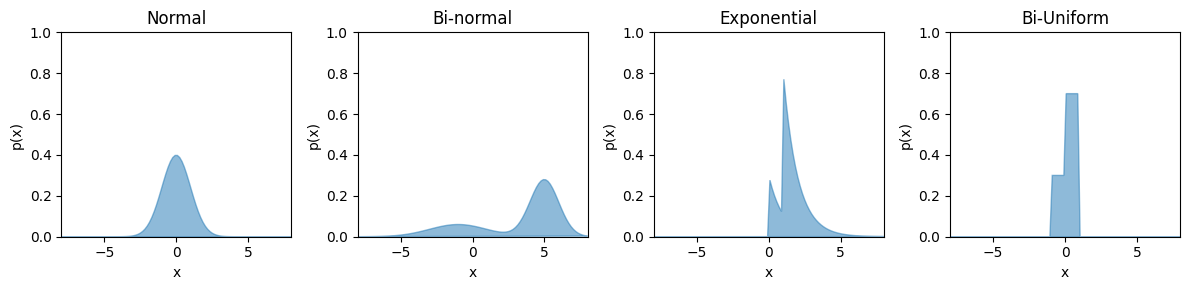

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
names = ['Normal', 'Bi-normal', 'Exponential', 'Bi-Uniform']
for i, d in enumerate([dist_norm, dist_binorm, dist_exp, dist_uni]):
    x = np.linspace(-8, 8, 100)
    ax[i].fill(x, d(x), color='C0', alpha=0.5)
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(-8, 8)
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('p(x)')
    ax[i].set_title(names[i])
fig.tight_layout()
fig.show()

In [28]:
def kernel(k: str):
    """Kernel Functions.
    Ref: https://en.wikipedia.org/wiki/Kernel_(statistics)

    Args:
        k (str): Kernel name. Can be one of ['gaussian', 'epanechnikov', 'cosine', 'linear'.]
    """
    
    if k not in ['gaussian', 'epanechnikov', 'cosine', 'linear']:
        raise ValueError('Unknown kernel.')

    def bounded(f):
        def _f(x):
            return f(x) if np.abs(x) <= 1 else 0
        return _f

    if k == 'gaussian':
        return lambda u: 1 / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * u * u)
    elif k == 'epanechnikov':
        return bounded(lambda u: (3 / 4 * (1 - u * u)))
    elif k =='cosine':
        return bounded(lambda u: np.pi / 4 * np.cos(np.pi / 2 * u))
    elif k == 'linear':
        return bounded(lambda u: 1 - np.abs(u))



In [29]:
def bw_scott(data: np.ndarray):
    std_dev = np.std(data, axis=0, ddof=1)
    n = len(data)
    return 3.49 * std_dev * n ** (-0.333)

def bw_silverman(data: np.ndarray):
    def _select_sigma(x):
        normalizer = 1.349
        iqr = (stats.scoreatpercentile(x, 75) - stats.scoreatpercentile(x, 25)) / normalizer
        std_dev = np.std(x, axis=0, ddof=1)
        return np.minimum(std_dev, iqr) if iqr > 0 else std_dev
    sigma = _select_sigma(data)
    n = len(data)
    return 0.9 * sigma * n ** (-0.2)

def bw_mlcv(data: np.ndarray, k):
    """
    Ref: https://rdrr.io/cran/kedd/src/R/MLCV.R
    """
    n = len(data)
    x = np.linspace(np.min(data), np.max(data), n)
    def mlcv(h):
        fj = np.zeros(n)
        for j in range(n):
            for i in range(n):
                if i == j: continue
                fj[j] += k((x[j] - data[i]) / h)
            fj[j] /= (n - 1) * h
        return -np.mean(np.log(fj[fj > 0]))
    h = optimize.minimize(mlcv, 1)
    if np.abs(h.x[0]) > 10:
        return bw_scott(data)
    return h.x[0]

In [31]:
def kde(data, k=None, h=None, x=None):
    """Kernel Density Estimation.

    Args:
        data (np.ndarray): Data.
        k (function): Kernel function.
        h (float): Bandwidth.
        x (np.ndarray, optional): Grid. Defaults to None.

    Returns:
        np.ndarray: Kernel density estimation.
    """
    if x is None:
        x = np.linspace(np.min(data), np.max(data), 1000)
    if h is None:
        h = bw_silverman(data)
    if k is None:
        k = kernel('gaussian')
    n = len(data)
    kde = np.zeros_like(x)
    for j in range(len(x)):
        for i in range(n):
            kde[j] += k((x[j] - data[i]) / h)
        kde[j] /= n * h
    return kde

/tmp/ipykernel_203885/1633289187.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fj[j] += k((x[j] - data[i]) / h)
/tmp/ipykernel_203885/1633289187.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fj[j] /= (n - 1) * h
/tmp/ipykernel_203885/1633289187.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fj[j] /= (n - 1) * h
/tmp/ipykernel_203885/1633289187.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will err

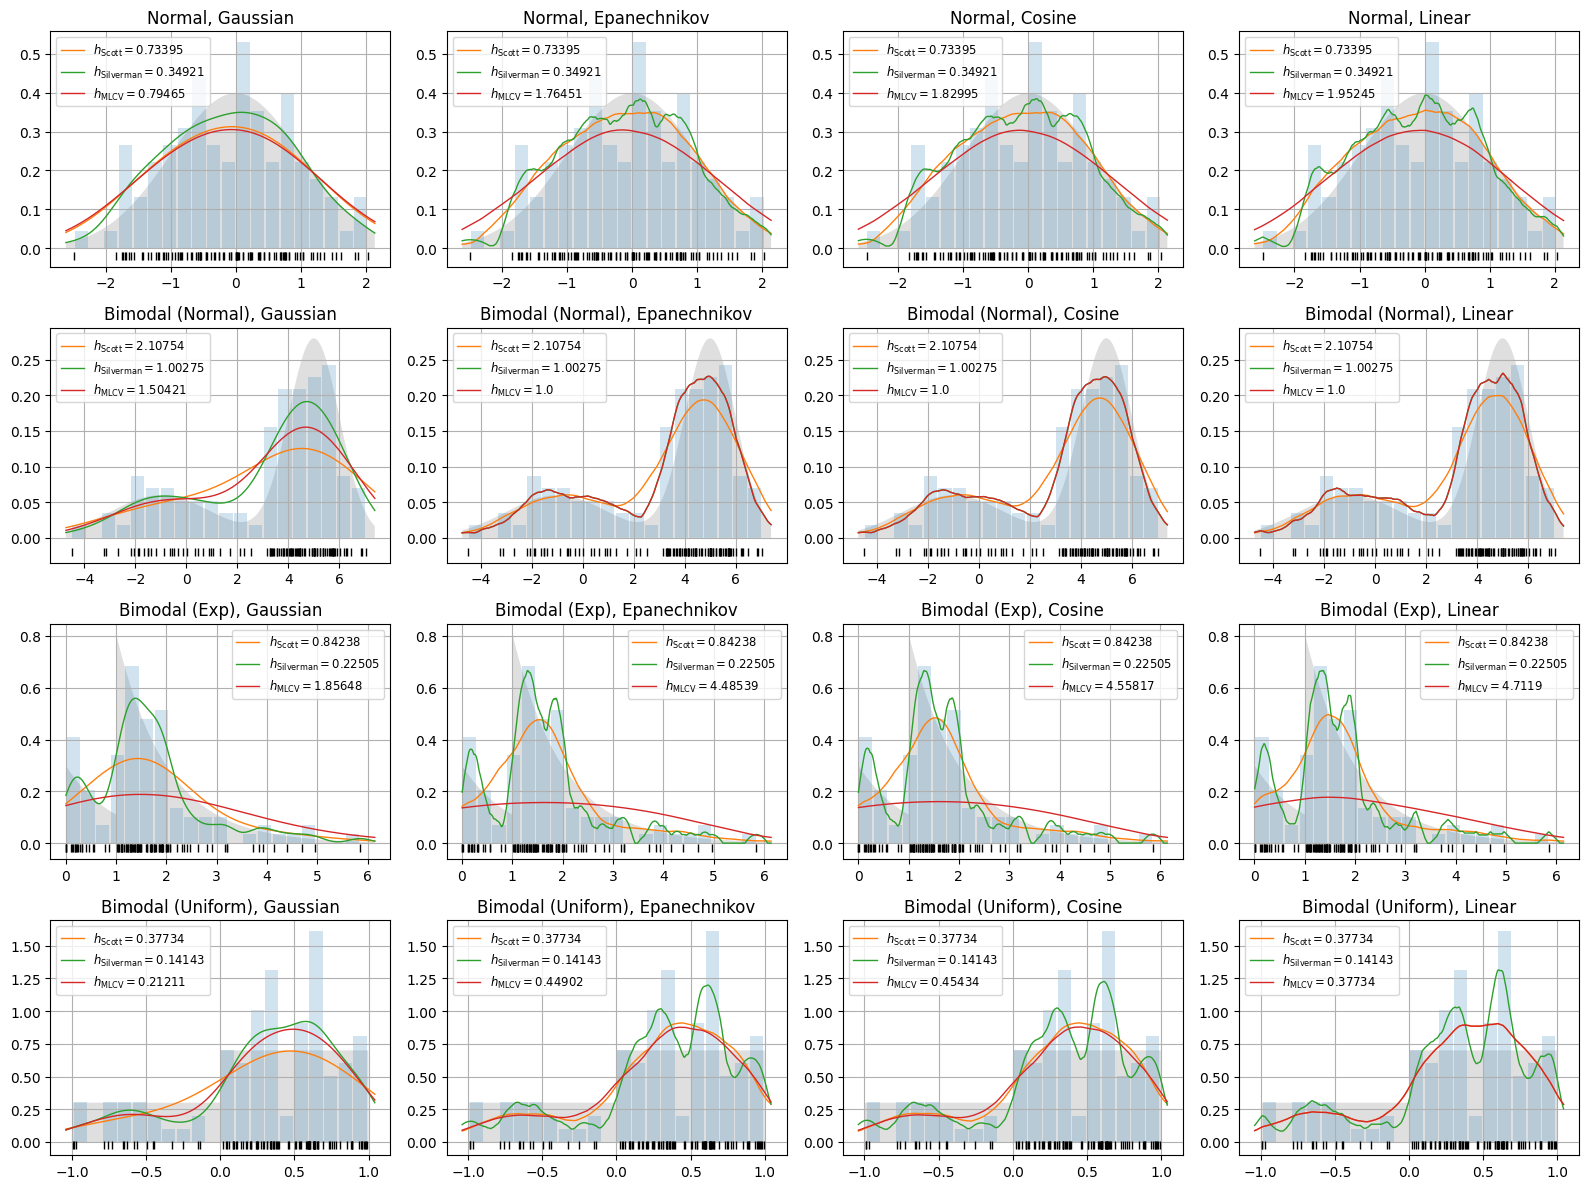

In [32]:
data = [
    ('Normal', make_data_normal),
    ('Bimodal (Normal)', make_data_binormal),
    ('Bimodal (Exp)', make_data_exp),
    ('Bimodal (Uniform)', make_data_uniform)
]
kernels = [
    ('Gaussian', kernel('gaussian')),
    ('Epanechnikov', kernel('epanechnikov')),
    ('Cosine', kernel('cosine')),
    ('Linear', kernel('linear'))
]
bw_algorithms = [
    ('Scott', bw_scott),
    ('Silverman', bw_silverman),
    ('MLCV', bw_mlcv),
]
mses = []

def run_kde(ax, data, kernel):
    x, dist = data[1]()
    x_plot = np.linspace(np.min(x) * 1.05, np.max(x) * 1.05, 1000)
    ax.grid(True)
    ax.fill_between(x_plot, dist(x_plot), fc='silver', alpha=0.5)
    ax.plot(x, np.full_like(x, -0.02), '|k', markeredgewidth=1)
    ax.hist(x, density=True, alpha=0.2, bins=20, rwidth=0.9)
    for bw in bw_algorithms:
        if bw[0] == 'MLCV':
            h = bw[1](x, kernel[1])
        else:
            h = bw[1](x)
        x_kde = kde(x, kernel[1], h=h, x=x_plot)
        mse = np.mean((dist(x_plot) - x_kde) ** 2)
        mses.append({
            'data': data[0],
            'kernel': kernel[0],
            'bw_algorithm': bw[0],
            'h': round(h, 5),
            'mse': round(mse * 1000, 5), # To make differences more noticable
        })
        ax.plot(x_plot, x_kde, linewidth=1, label='$h_{\mathrm{' + bw[0] + '}} = ' + str(round(h, 5)) + '$')
    ax.legend(loc='best', fontsize='small')
    ax.set_title(f'{data[0]}, {kernel[0]}')

fig, axs = plt.subplots(len(data), len(kernels), figsize=(16, 12))

for i, d in enumerate(data):
    for j, k in enumerate(kernels):
        run_kde(axs[i, j], d, k)
    for bw in bw_algorithms:
        avg_h = np.mean([m['h'] for m in mses if m['data'] == d[0] and m['bw_algorithm'] == bw[0]])
        avg_mse = np.mean([m['mse'] for m in mses if m['data'] == d[0] and m['bw_algorithm'] == bw[0]])
        mses.append({
            'data': d[0],
            'kernel': '-',
            'bw_algorithm': bw[0],
            'h': round(avg_h, 5),
            'mse': round(avg_mse, 5),
        })

fig.tight_layout()
fig.show()
fig.savefig('eval.pdf')
pd.DataFrame(mses).to_csv('eval.csv', index=False)

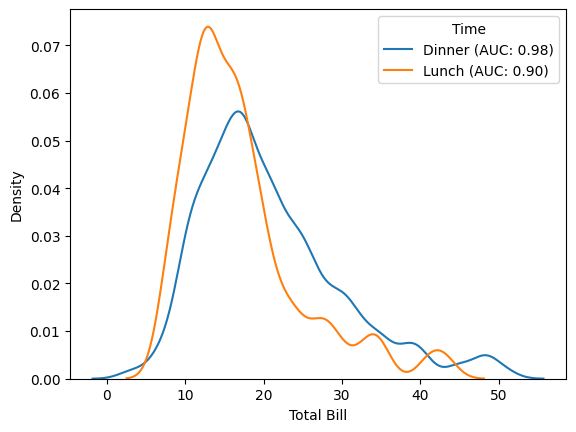

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.integrate import quad

# Load the tips dataset
tips = sns.load_dataset("tips")

# Function to calculate area under the curve
def calculate_auc(data, bw_adjust):
    kde = gaussian_kde(data, bw_method=bw_adjust)
    xmin, xmax = data.min(), data.max()
    auc, _ = quad(kde, xmin, xmax)
    return auc

# Plot KDE for different categories and calculate AUC
bw_adjust = 0.5
for time in tips['time'].unique():
    subset = tips[tips['time'] == time]['total_bill']
    sns.kdeplot(data=subset, bw_adjust=bw_adjust, label=f'{time} (AUC: {calculate_auc(subset, bw_adjust):.2f})')

plt.xlabel('Total Bill')
plt.ylabel('Density')
plt.legend(title='Time')
plt.show()
